# Getting Started

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [ ]:
train_dir = '/content/drive/MyDrive/archive/RashData/Train'
val_dir = '/content/drive/MyDrive/archive/RashData/Validation'

In [ ]:
batch_size = 32

img_height = 128
img_width = 128

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=42,
    subset='training',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=42,
    subset='validation',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 357 files belonging to 1 classes.
Using 286 files for training.
Found 357 files belonging to 1 classes.
Using 71 files for validation.
Found 87 files belonging to 1 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Train_2_Cases']


# Visualization

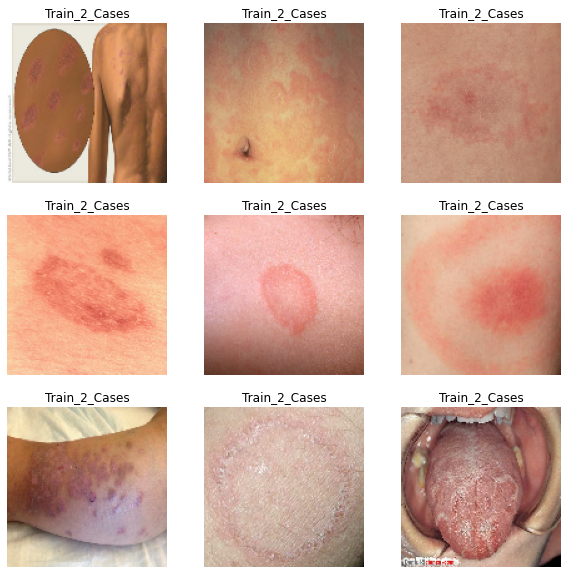

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Modeling

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN (Functional Model)

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640  

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
epochs = 45

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0
)

## CNN (Sequential)

In [ ]:
import keras

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='softmax')
])

# Results

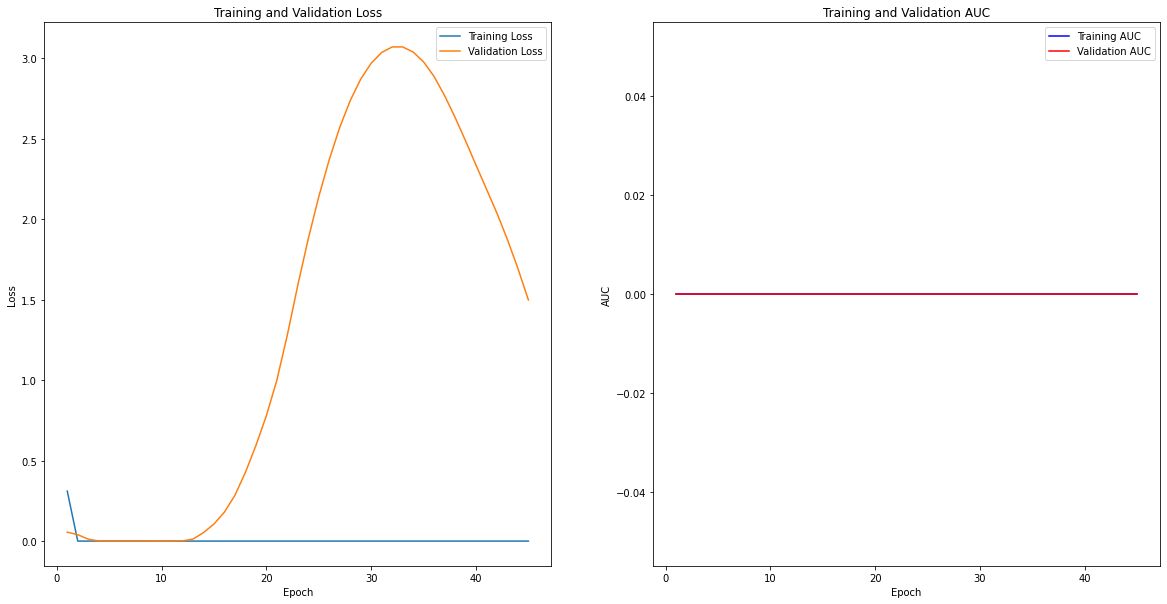

In [ ]:
plt.figure(figsize=(20, 10))

epochs_range = range(1, epochs + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_auc, label="Training AUC", color='b')
plt.plot(epochs_range, val_auc, label="Validation AUC", color='r')

plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training and Validation AUC")
plt.legend()

plt.show()

In [ ]:
np.argmin(val_loss)

5

In [ ]:
np.argmax(val_auc)

0

In [ ]:
model.evaluate(test_ds)

3/3 [==============================] - 8s 88ms/step - loss: 0.6702 - accuracy: 0.9195 - auc: 0.0000e+00


[0.6701571345329285, 0.9195402264595032, 0.0]

In [ ]:
model.save

<bound method Model.save of <keras.engine.functional.Functional object at 0x7fccc967e390>>